In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

import re
import string
from nltk.stem.snowball import *

## Part 2

##### ---> adding convolutional layer

In [2]:
df = pd.read_csv('new_yelp.csv', index_col=0, low_memory=False)

In [3]:
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,labels
3343256,zthVOctc7sTONdtEjoi6Vg,tqxTc21Df_qLSmSbZk447g,59OgPGGzKFYqwSG_U06kuA,5,2015-03-23,This is my favorite Korean restaurant in Arizo...,3.0,0.0,0.0,1.0
3160600,tmOC1c0laXLdTwRk7Ik3lg,qszR--MaJ_qWUt-laMXFBw,U4OLUFb9VxMmpMXm1ZF-cQ,4,2012-05-08,I come in here every week for some delicious c...,0.0,0.0,0.0,1.0
2541439,cN444GYzJd7k52x8xUHzUw,rt3PC7WCgCKsoufmQJELfw,g8OnV26ywJlZpezdBnOWUQ,4,2009-09-10,We joined our out-of-town guests for breakfast...,11.0,5.0,8.0,1.0
3356848,5w3kt0iaS5ifweyE0sYFhw,XlgzY-TioqNy--pxPBoH4Q,5DDumAHRKumv3gZiPKW6iw,5,2012-05-20,"First of all, the people who work here are gre...",0.0,0.0,2.0,1.0
1215656,3ZkPcaRfX3jp7IRgtmwlqg,oN4Dq_aZuOkapFgjrVVK_w,EgRpbUZKPiotTXdrOM06VA,4,2012-09-23,What a fantastic find! We came here based on t...,0.0,0.0,0.0,1.0


In [4]:
df = df[~df.isna().any(axis=1)]

In [5]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    stops = set(stopwords.words('english'))
    text = [word for word in text if (word not in stops) & (len(word) > 3)]
    text = ' '.join(text)
    
    #Cleaning
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)    
    
    #Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = ' '.join(stemmed_words)
    
    return text

In [6]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [7]:
voc_size = 20000
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(df['text'])

seqs = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(seqs, maxlen=50)

In [11]:
%%time
model = Sequential()
model.add(Embedding(voc_size, 100, input_length=50))
model.add(Dropout(.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.fit(data, df['labels'], validation_split=0.4, epochs=3)

Train on 1041810 samples, validate on 694540 samples
Epoch 1/3
1041810/1041810 [==============================] - 2232s 2ms/step - loss: 0.2850 - acc: 0.8777 - val_loss: 0.2681 - val_acc: 0.8852
Epoch 2/3
1041810/1041810 [==============================] - 2265s 2ms/step - loss: 0.2527 - acc: 0.8935 - val_loss: 0.2617 - val_acc: 0.8894
Epoch 3/3
1041810/1041810 [==============================] - 2315s 2ms/step - loss: 0.2369 - acc: 0.9011 - val_loss: 0.2698 - val_acc: 0.8887
Wall time: 1h 53min 34s


In [12]:
word_embs = model.layers[0].get_weights()[0]

In [13]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(word_embs)

In [14]:
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [15]:
number_of_words = 1000
trace = go.Scatter(
    x=X_embedded[0:number_of_words,0], 
    y=X_embedded[0:number_of_words,1],
    mode='markers',
    text=word_list[0:number_of_words]
)
layout = dict(title='t-SNE 1 vs t-SNE 2 for first 1000 words ',
              yaxis=dict(title='t-SNE 2'),
              xaxis=dict(title='t-SNE 1'),
              hovermode='closest')
fig = dict(data=[trace], layout=layout)
py.iplot(fig)

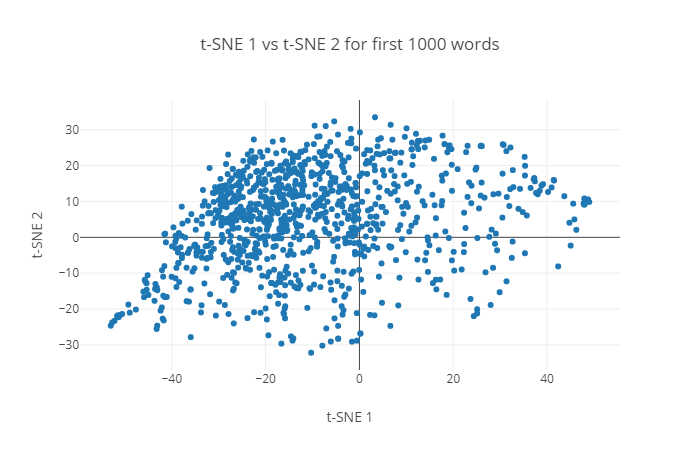

In [16]:
from IPython.display import Image
Image(filename='newplot2.png')